In [2]:
import pickle 
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset
class ARGS():
    def __init__(self):
        # self.models = ['Llama-2-7b-hf','Qwen-1_8B','falcon-7b','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','mpt-7b','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        # self.models = ['Llama-2-7b-hf','Qwen-1_8B','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        # self.models = ['Yi-34B','Qwen-14B','Yi-6B','Qwen-72B','deepseek-llm-67b-base','Llama-2-70b-hf']
        self.models = ['Qwen-14B','Yi-6B']
        self.logits_data_dir = "D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/outputs_base"
        self.raw_data_dir = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data'
        # self.data_names = ['mmlu_10k', 'cosmosqa_10k', 'hellaswag_10k', 'halu_dialogue', 'halu_summarization']
        self.data_names = ['mmlu_10k']
        self.tasks = {'mmlu_10k':'QA', 'cosmosqa_10k':'RC', 'hellaswag_10k':'CI', 'halu_dialogue':'DRS', 'halu_summarization':'DS'}
        self.alpha = 0.1
args = ARGS()


In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--model", type=str, default="Qwen-72B")
parser.add_argument("--raw_data_dir", type=str, default="data",
                    help="Directory where raw data are stored.")
parser.add_argument("--logits_data_dir", type=str, default="outputs_base",
                    help="Directory where logits data are stored.")
parser.add_argument("--data_names", nargs='*', 
                    default=['mmlu_10k', 'cosmosqa_10k', 'hellaswag_10k', 'halu_dialogue', 'halu_summarization'], 
                    help='List of datasets to be evaluated. If empty, all datasets are evaluated.')
parser.add_argument("--prompt_methods", nargs='*', 
                    default=['base', 'shared', 'task'], 
                    help='List of prompting methods. If empty, all methods are evaluated.')
parser.add_argument("--icl_methods", nargs='*', 
                    default=['icl1'], 
                    help='Select from icl1, icl0, icl0_cot.')
parser.add_argument("--cal_ratio", type=float, default=0.5,
                    help="The ratio of data to be used as the calibration data.")
parser.add_argument("--alpha", type=float, default=0.1,
                    help="The error rate parameter.")
args = parser.parse_args()

get_SPU(args)

usage: ipykernel_launcher.py [-h] [--model MODEL]
                             [--raw_data_dir RAW_DATA_DIR]
                             [--logits_data_dir LOGITS_DATA_DIR]
                             [--data_names [DATA_NAMES ...]]
                             [--prompt_methods [PROMPT_METHODS ...]]
                             [--icl_methods [ICL_METHODS ...]]
                             [--cal_ratio CAL_RATIO] [--alpha ALPHA]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\7718\AppData\Roaming\jupyter\runtime\kernel-v3734e531ef4b06452c55d4b6bac4b3314939d94c6.json


SystemExit: 2

d:\anaconda\envs\pytorch\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result
def get_SPU(args):
    """
    0~5:softmax score for option
    6:variance
    7~12:prediction(one hot)
    13:uncertainty
    14:type
    """
    SPU = {}
    for model in args.models:
        SPU[model] = []
        for data_name in args.data_names:
            logits_file = os.path.join(args.logits_data_dir, model+"_"+data_name+"_base_icl1.pkl")
            with open(logits_file, 'rb') as f:
                logits_data = pickle.load(f)
            softmax_data = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_data)]))
            softmax_data = np.column_stack((softmax_data, np.var(softmax_data[:, :4], axis=1)))
            softmax_data = np.column_stack((softmax_data, np.argmax(softmax_data[:, :4],axis=1)))
            softmax_pred_data = np.column_stack((softmax_data, OneHotEncoder(sparse_output=False).fit_transform(np.argmax(softmax_data[:, :4],axis=1).reshape(-1, 1))))
            softmax_pred_uncertainty_data = np.column_stack((softmax_pred_data, 1 - np.max(softmax_pred_data[:,:4], axis=1)))
            type = args.data_names.index(data_name)
            softmax_pred_uncertainty_type_data = np.column_stack((softmax_pred_uncertainty_data, np.full(softmax_pred_uncertainty_data.shape[0], type)))
            SPU[model].append(softmax_pred_uncertainty_type_data)
        SPU[model] = np.array(SPU[model])
    return SPU
def get_raw_data(args):
    mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    raw_data_all = []
    for data_name in args.data_names:
        raw_data = json.load(open(os.path.join(args.raw_data_dir, data_name + ".json"), "r"))
        arr = np.array([item['answer'] for _, item in enumerate(raw_data)])
        mapped_array = np.vectorize(mapping.get)(arr)
        raw_data_all.append(mapped_array)
    return np.array(raw_data_all)
def get_combined_feature(SPU, num_model_feature, col_model_pred = 7):
    combined_feature = np.hstack([SPU[model].reshape(-1,SPU[model].shape[-1]) for model in args.models])
    def entropy(probabilities):
        probabilities = np.array(probabilities)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # 1e-10 防止 log(0)
        return max(0,entropy)
    pred_columns = combined_feature[:, col_model_pred::num_model_feature]
    entropies = []
    for row in pred_columns:
        unique, counts = np.unique(row, return_counts=True)  # 统计每一行中各类别的出现次数
        probabilities = counts / np.sum(counts)  # 计算每个类别的概率
        entropies.append(entropy(probabilities))  # 计算熵
    return np.column_stack((combined_feature, np.array(entropies)))

In [4]:
def plot_accuracy(results, title, save):
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    if save:
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/unc_acc_figure/{title}.png')
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/unc_acc_figure/{title}.svg')
    else: plt.title(title)
    plt.show()
def uncertainty_acc_result(title, PUT_data, cal = False, plot_results = True, save = True):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        p = PUT_data[:, -3]
        u = PUT_data[:, -2]
        t = PUT_data[:, -1]
        if cal: 
            # bucket algorithm
            quantiles = np.percentile(u, np.arange(10, 101, 10))
            new_u = np.zeros(len(u))
            for i, q in enumerate(quantiles):
                if i == 0:
                    new_u[u <= q] = i * 0.1
                else:
                    new_u[(u > quantiles[i - 1]) & (u <= q)] = i * 0.1
            mask = new_u <= threshold 
        else: mask = u <= threshold 
        acc = (p == t)[mask].sum() / max(1, sum(mask))
        perc_data = mask.mean()
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    results = results[results[:,2]>0]
    if plot_results:
        plot_accuracy(results, title, save)
    return results

In [15]:
SPU = get_SPU(args)
# SPU, num_model_feature, col_model_pred = get_SPU(args)
# T = np.expand_dims(get_raw_data(args), axis=2)
# data_all = SPU.copy()
# for model in args.models:
#     data_all[model] = np.concatenate((SPU[model], T), axis=2).round(2)


In [16]:
SPU['Qwen-14B'].shape

(1, 10000, 14)

In [13]:
SPU['Qwen-14B'][0][0]

array([9.95949149e-01, 2.07886309e-03, 7.89047568e-04, 8.73395882e-04,
       2.60200264e-04, 4.92736326e-05, 1.85518786e-01, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.05085087e-03,
       0.00000000e+00])

In [7]:
y = get_raw_data(args)

array([[0, 0, 1, ..., 3, 1, 3],
       [1, 3, 1, ..., 2, 1, 0],
       [3, 1, 0, ..., 3, 1, 0],
       [2, 3, 3, ..., 2, 0, 3],
       [2, 3, 3, ..., 2, 0, 3]])

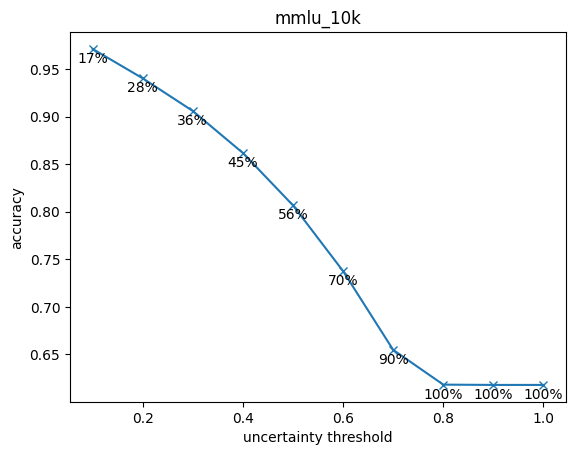

In [20]:
y = get_raw_data(args)
for i in range(SPU['Yi-6B'].shape[0]):
    data = SPU['Yi-6B'][i]
    P = data[:, 7]
    U = data[:, 12]
    PUT_data = np.column_stack((P, U, y[i]))
    uncertainty_acc_result(args.data_names[i], PUT_data, save = False)

In [5]:
X = get_combined_feature(SPU, num_model_feature, col_model_pred)
y = get_raw_data(args).flatten()
random_state = 78

In [180]:
# X = X[:,[i for i in range(X.shape[-1]) if i % num_model_feature == 4]]
X = X[:,[i for i in range(X.shape[-1]) if (i % num_model_feature) in [0,1,2,3,4,5]]]
X = X[:, :-1]
# X = np.delete(X, [i for i in range(X.shape[-1]) if i % num_model_feature == 4], axis=1)
para = '14model_S'
num_model_feature = 6
# col_model_pred = 0

In [130]:
X.shape

(50000, 36)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
    # if model == cat_clf: y_pred = y_pred.flatten()
    # return (f1_macro, accuracy, y_pred, 1 - np.max(y_pred_proba,axis=1))
    return (f1_macro, accuracy, y_pred)
# 初始化模型
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=random_state)
svm_clf = SVC(decision_function_shape='ovr',probability=True)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
lgb_clf = lgb.LGBMClassifier(num_leaves=15, n_estimators=100, random_state=random_state)
# cat_clf = CatBoostClassifier(iterations=100, random_state=random_state, verbose=0)
# 对各个模型进行评估
dc_ml = {
        # 'Logistic Regression': evaluate_model(log_reg, X_train, y_train, X_test, y_test),
        # 'Decision Tree': evaluate_model(tree_clf, X_train, y_train, X_test, y_test),
        'SVM': evaluate_model(svm_clf, X_train, y_train, X_test, y_test),
        'Random Forest': evaluate_model(rf_clf, X_train, y_train, X_test, y_test),
        'XGBoost': evaluate_model(xgb_clf, X_train, y_train, X_test, y_test),
        'LightGBM': evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
        # 'CatBoost': evaluate_model(cat_clf, X_train, y_train, X_test, y_test)
        }

d:\anaconda\envs\pytorch\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21420
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 84
[LightGBM] [Info] Start training from score -1.396749
[LightGBM] [Info] Start training from score -1.393420
[LightGBM] [Info] Start training from score -1.381904
[LightGBM] [Info] Start training from score -1.373279


In [182]:
S_avg = np.mean([SPU[model].reshape(-1,SPU[model].shape[-1])[:,:4] for model in args.models], axis=0)
train_S_avg, test_S_avg = train_test_split(S_avg, test_size=0.2, random_state=random_state)

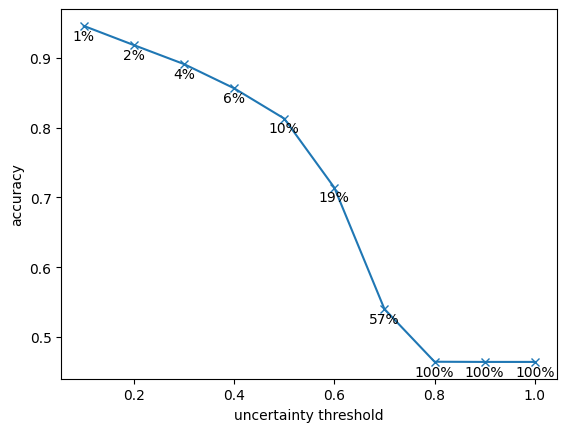

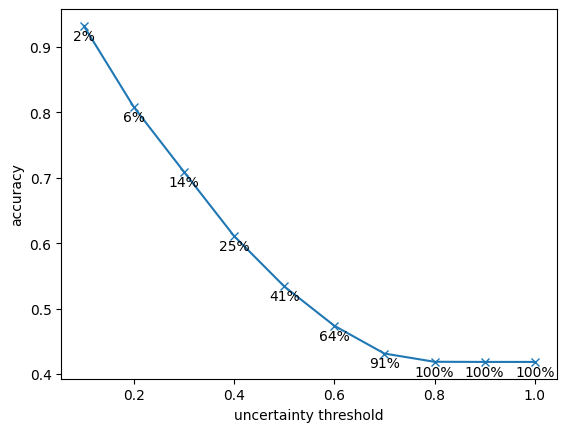

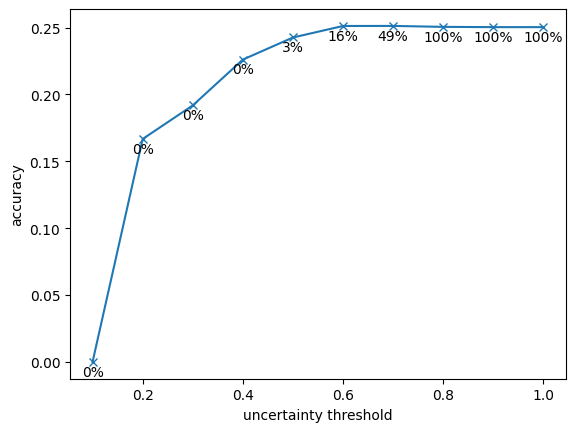

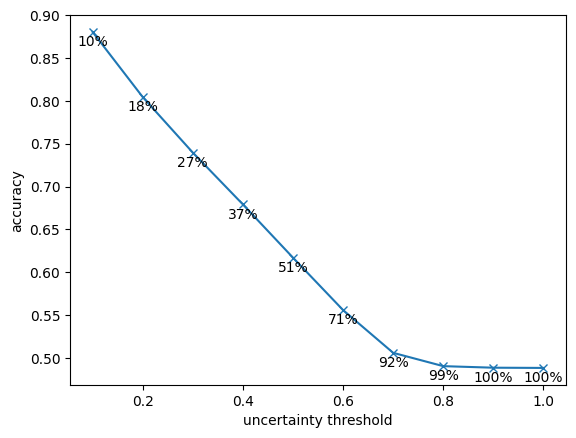

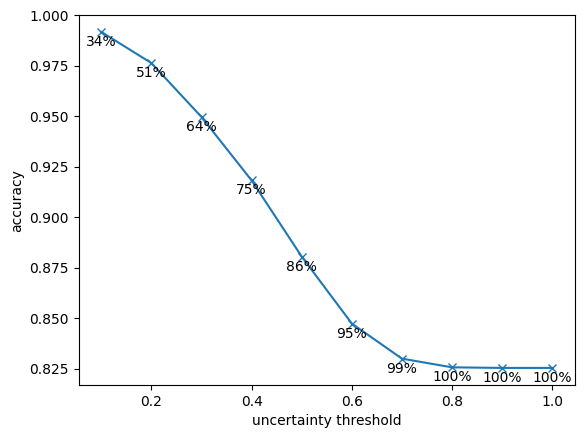

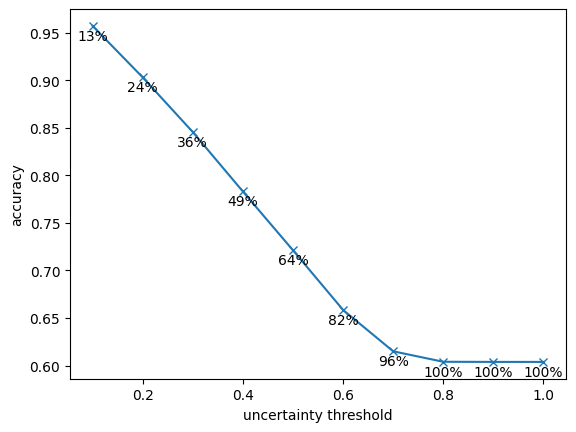

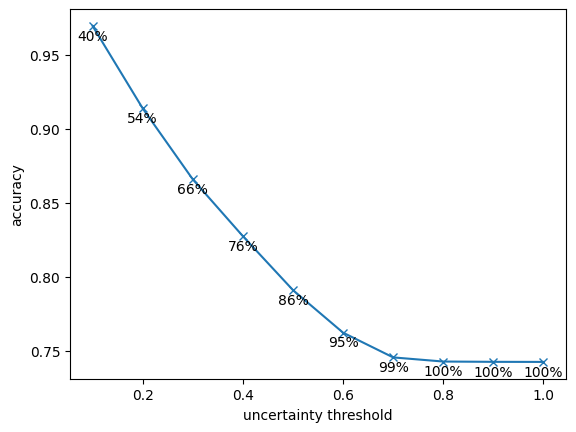

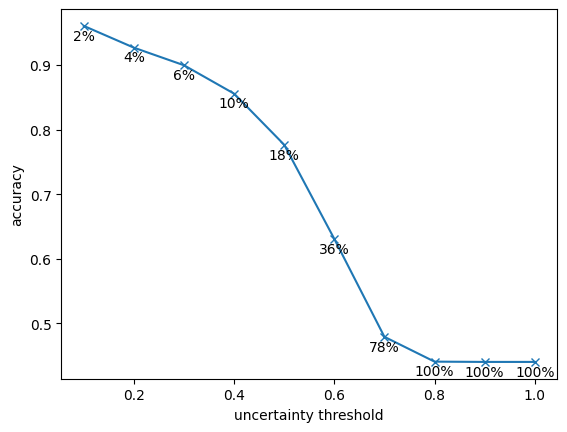

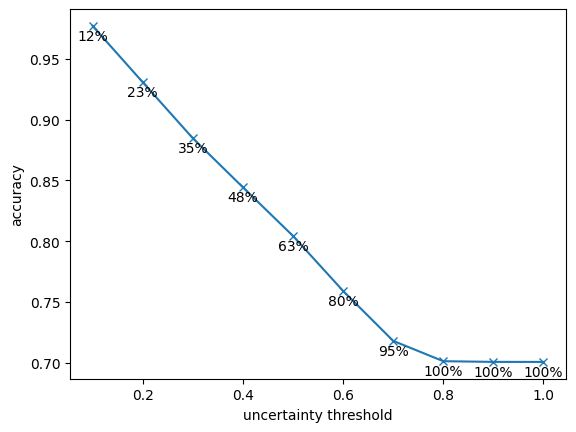

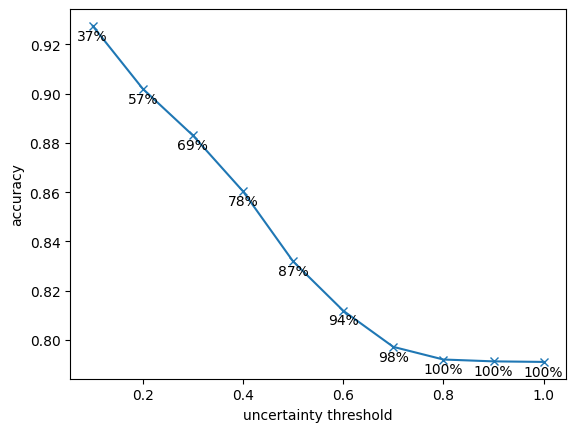

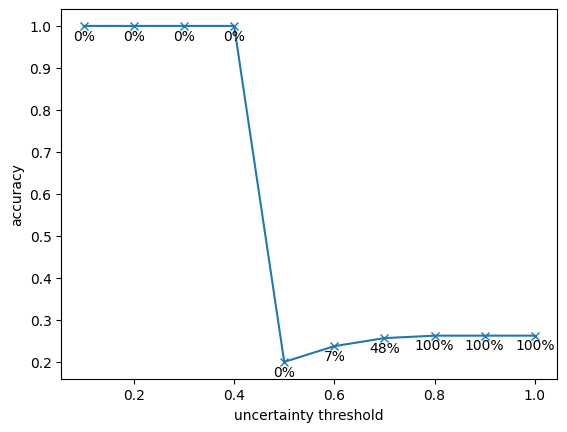

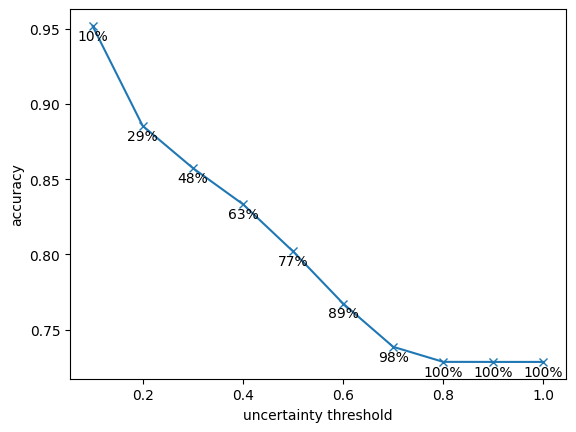

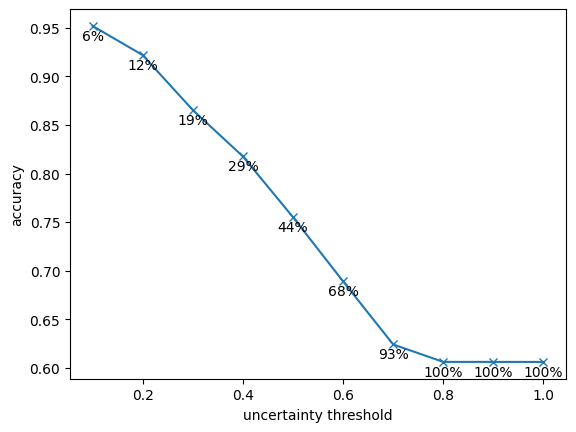

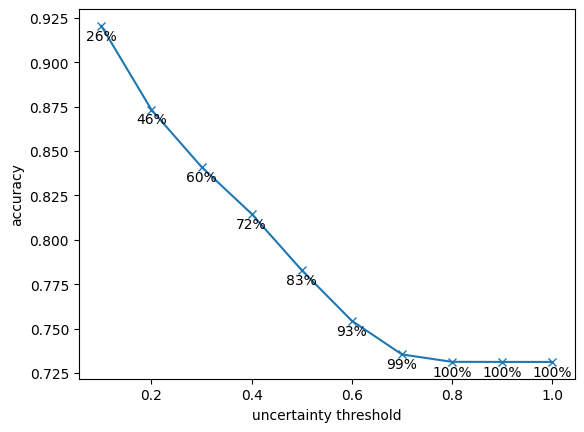

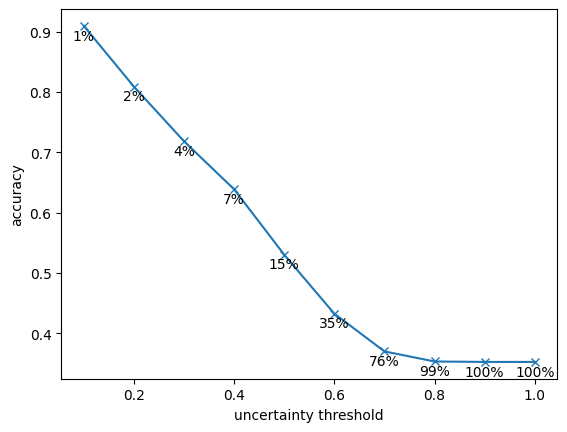

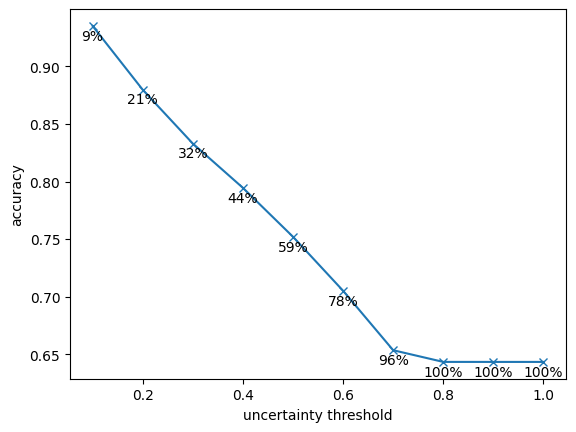

In [175]:
# singal model
result = {}
for method in args.models:
    P = SPU[method].reshape(-1,SPU[method].shape[-1])[:,7].astype(int)
    U = SPU[method].reshape(-1,SPU[method].shape[-1])[:,8]
    PUT_data = np.column_stack((P, U, y))
    result[method] = uncertainty_acc_result(method, PUT_data, cal = False)

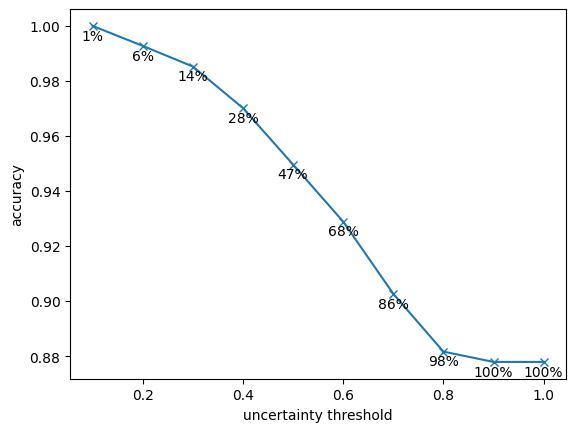

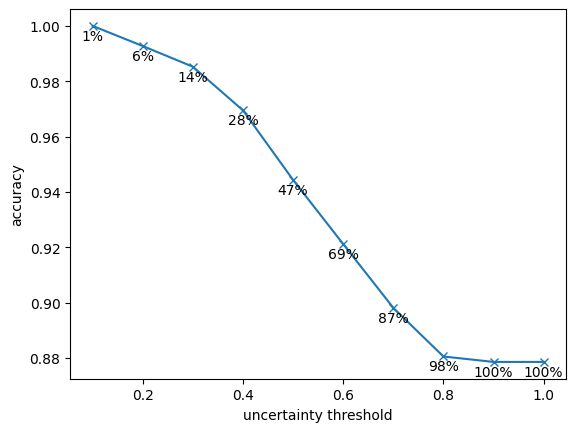

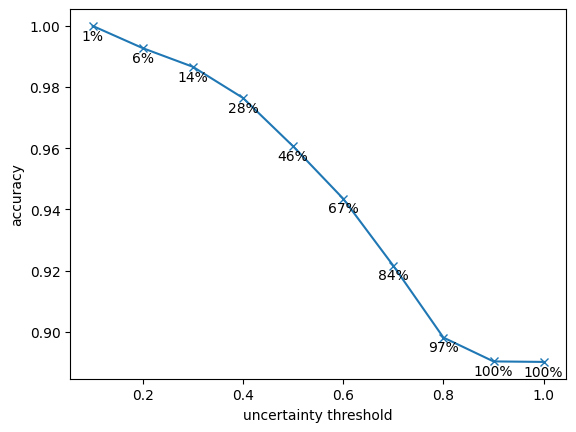

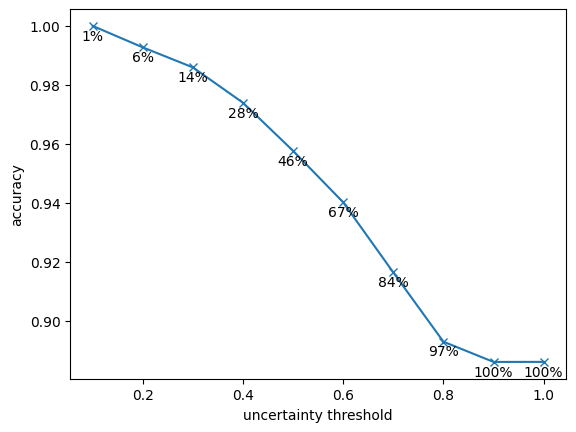

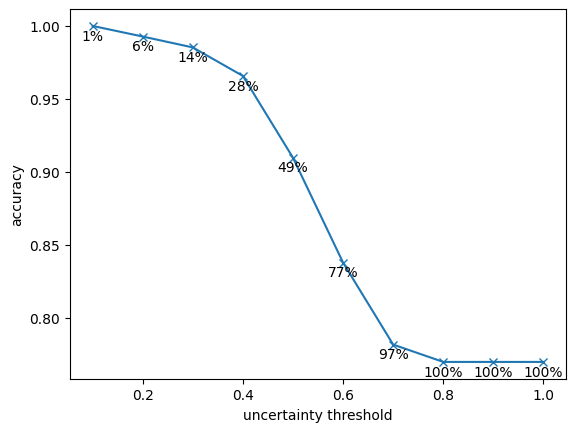

In [183]:
# dc_ml[args.models[4]] = X_test[:,4*8+6]
# for i in range(len(args.models)):
#     dc_ml[args.models[i]] = X_test[:,i*8+6]
# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# # Yi_U = 1 - test_S_avg[np.arange(len(Yi_P)), Yi_P]
# dc_ml[args.models[4]] = (1,1,Yi_P)
# dc_ml.pop(args.models[4])
baseline_pred = np.argmax(test_S_avg, axis=1)
dc_ml['baseline'] = (f1_score(y_test, baseline_pred, average='macro'), accuracy_score(y_test, baseline_pred),baseline_pred)
result = {}
for method in dc_ml.keys():
    P = dc_ml[method][2].astype(int)
    U = 1 - test_S_avg[np.arange(len(P)), P]
    PUT_data = np.column_stack((P, U, y_test))
    result[method] = uncertainty_acc_result(method+f' {para}', PUT_data, cal = False)

# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# Yi_U = X_test[:,4*num_model_feature+col_model_pred+1]
# PUT_data = np.column_stack((Yi_P, Yi_U, y_test))
# result['Yi_P'] = uncertainty_acc_result(method, PUT_data, cal = False)

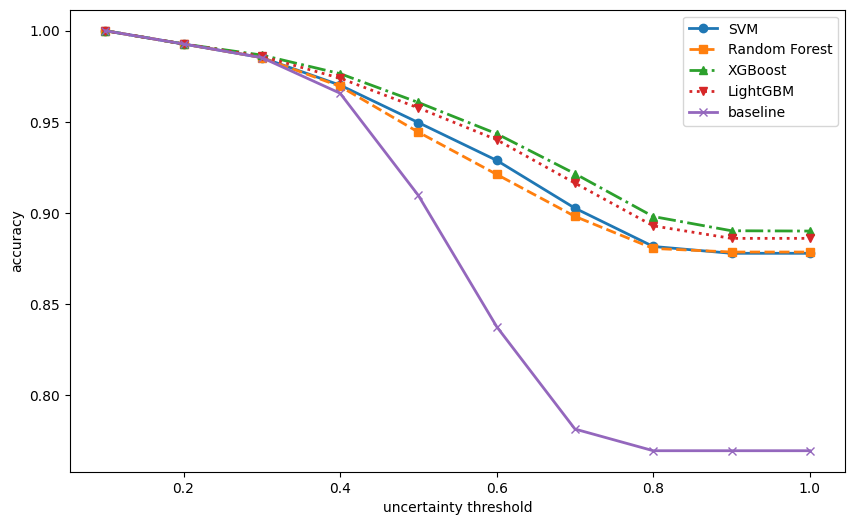

In [184]:
def plot_accuracy_multiple(models_results, title='Model Accuracy Comparison'):
    """
    models_results 是一个列表，包含多个 (model_name, results) 的元组。
    model_name 是字符串，results 是对应模型的 10行3列 二维数组。
    """
    plt.figure(figsize=(10, 6))  # 设置图像大小
    linestyles = ['-', '--', '-.', ':']  # 不同的线型
    markers = ['o', 's', '^', 'v', 'x']  # 不同的标记
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 可选的颜色
    for i, model in enumerate(result):
        xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
        # # 为每个模型的每个点添加注释
        # for x, y, z in zip(xs, ys, zs):
        #     label = "{:.0f}%".format(100 * z)
        #     plt.annotate(label,  # 这个是标注的文本
        #                  (x, y),  # 这些是标注的坐标
        #                  textcoords="offset points",  # 文本的显示位置
        #                  xytext=(0, -10),  # 文本与点的距离
        #                  ha='center')  # 水平对齐方式
        # 使用不同的线型和标记，每次循环中循环使用它们
        plt.plot(xs, ys, label=model, 
                linestyle=linestyles[i % len(linestyles)],  # 循环使用线型
                marker=markers[i % len(markers)],  # 循环使用标记
                color=colors[i % len(colors)],  # 循环使用颜色
                markersize=6,  # 标记大小
                linewidth=2)  # 线宽
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.legend()  # 显示图例，区分不同模型
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/comparison/{title}.png')
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/comparison/{title}.svg')
    plt.show()
plot_accuracy_multiple(result,title=f'Model Accuracy Comparison {para}')

In [159]:
result

{'Llama-2-7b-hf': array([[0.1       , 0.94604317, 0.01112   ],
        [0.2       , 0.91850594, 0.02356   ],
        [0.3       , 0.89128205, 0.039     ],
        [0.4       , 0.85658663, 0.06164   ],
        [0.5       , 0.81315156, 0.09976   ],
        [0.6       , 0.71407972, 0.19418   ],
        [0.7       , 0.53996237, 0.57404   ],
        [0.8       , 0.46430073, 0.99918   ],
        [0.9       , 0.46404   , 1.        ],
        [1.        , 0.46404   , 1.        ]]),
 'Qwen-1_8B': array([[0.1       , 0.93176179, 0.01612   ],
        [0.2       , 0.80761844, 0.06248   ],
        [0.3       , 0.70878564, 0.13818   ],
        [0.4       , 0.61073013, 0.2479    ],
        [0.5       , 0.53390244, 0.41      ],
        [0.6       , 0.47376615, 0.6423    ],
        [0.7       , 0.43131892, 0.9068    ],
        [0.8       , 0.41875601, 0.99872   ],
        [0.9       , 0.41854   , 1.        ],
        [1.        , 0.41854   , 1.        ]]),
 'falcon-7b': array([[1.00000000e-01, 0.000000

In [185]:
dc_f1_acc = {}
print("Model Comparison:")
for method in dc_ml.keys():
    dc_f1_acc[method] = (dc_ml[method][0], dc_ml[method][1])
# for i in range(len(args.models)):  
#     dc_f1_acc[args.models[i]] = (f1_score(y_test, X_test[:,i*num_model_feature+col_model_pred], average='macro'), accuracy_score(y_test, X_test[:,i*num_model_feature+col_model_pred]))
for id in dc_f1_acc.keys():
    print("F1-score: {:.4f}, Accuracy: {:.4f}   --{}".format(dc_f1_acc[id][0], dc_f1_acc[id][1], id))
    
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/result_json/result_{para}.json', 'w') as file:
    json.dump(result, file, indent=4)

Model Comparison:
F1-score: 0.8779, Accuracy: 0.8779   --SVM
F1-score: 0.8786, Accuracy: 0.8786   --Random Forest
F1-score: 0.8901, Accuracy: 0.8901   --XGBoost
F1-score: 0.8861, Accuracy: 0.8861   --LightGBM
F1-score: 0.7692, Accuracy: 0.7696   --baseline


In [166]:
dc_f1_acc = {}
for method in args.models:
    P = SPU[method].reshape(-1,SPU[method].shape[-1])[:,7].astype(int)
    dc_f1_acc[method] = (f1_score(y, P, average='macro'), accuracy_score(y, P))
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/result_json/result_single_model.json', 'w') as file:
    json.dump(result, file, indent=4)

In [173]:
with open('D:/git-code/updated_code/ollama_fact/json_file/result_json/'+'result_14model_S.json', 'r') as file:
    data_S = json.load(file)
data_S['f1_acc']

{'SVM': [0.8779045957200038, 0.8779],
 'Random Forest': [0.8798714829723187, 0.8799],
 'XGBoost': [0.8932791748220299, 0.8933],
 'LightGBM': [0.8868764944303285, 0.8869],
 'baseline': [0.7711031173238534, 0.7715]}

In [146]:
data['f1_acc']

{'SVM': [0.8583754208052579, 0.8584],
 'Random Forest': [0.8782711068732239, 0.8783],
 'XGBoost': [0.8945889299716457, 0.8946],
 'LightGBM': [0.888666604102998, 0.8887],
 'baseline': [0.7660844153755884, 0.7667],
 'Llama-2-7b-hf': [0.4520057132040955, 0.4538],
 'Qwen-1_8B': [0.4033973771791605, 0.4127],
 'falcon-7b': [0.21608881506495264, 0.2481],
 'internlm-7b': [0.4809624730267863, 0.4884],
 'Yi-34B': [0.8286136317032085, 0.8288],
 'Qwen-7B': [0.5927285651231905, 0.5939],
 'Qwen-14B': [0.739897744884987, 0.7405],
 'deepseek-llm-7b-base': [0.4312597428146766, 0.4388],
 'Yi-6B': [0.6999130089238268, 0.7005],
 'Qwen-72B': [0.7863862084604255, 0.7864],
 'mpt-7b': [0.2406173821640506, 0.2676],
 'deepseek-llm-67b-base': [0.7221257211043925, 0.7228],
 'Llama-2-13b-hf': [0.6038190230592068, 0.6046],
 'Llama-2-70b-hf': [0.7267398470988986, 0.727],
 'falcon-40b': [0.34887790631272697, 0.3508],
 'Mistral-7B-v0.1': [0.6408086826084838, 0.6416]}

In [154]:

def dict_to_latex_table(data):
    headers = ['model','F1-score','Accuracy']
    
    latex_code = "\\begin{tabular}{" + " | ".join(['c'] * len(headers)) + "}\n\\hline\n"
    latex_code += " & ".join(headers) + " \\\\\n\\hline\n"
    for key in data.keys():
        latex_code += key
        for i in data[key]:
            # print(i)
            latex_code += " & " + str(np.round(i,4))
        latex_code+= " \\\\\n"
    latex_code += "\\hline\n\\end{tabular}"
    return latex_code

# 将 dict 转换为 LaTeX 表格
latex_table = dict_to_latex_table(data_S['f1_acc'])

# 输出 LaTeX 表格代码
print(latex_table)


\begin{tabular}{c | c | c}
\hline
model & F1-score & Accuracy \\
\hline
SVM & 0.8794 & 0.8794 \\
Random Forest & 0.8795 & 0.8795 \\
XGBoost & 0.896 & 0.896 \\
LightGBM & 0.8896 & 0.8896 \\
baseline & 0.7661 & 0.7667 \\
\hline
\end{tabular}
